# Prep

Setting up some prior functionality

In [21]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.2.1+cu118 True


In [22]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


# Load a model

First we have to decide if our model should be pretrained. 

This greatly depends on the size of a dataset. Smaller datasets rely more on finetuning. 

In [23]:
pretrained = True

if pretrained:
    # Get pretrained weights
    checkpoint = torch.hub.load_state_dict_from_url(
                url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
                map_location='cuda',
                check_hash=True)

    # Remove class weights
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]

    # SaveOGH
    torch.save(checkpoint,
               'detr-r50_no-class-head.pth')

# Dataset

Our dataset should be loadable as a COCO format

This allows us to use the pycocotools to load the data dict for the main python script

In [24]:
dataset_file = "coco" # alternatively, implement your own coco-type dataset loader in datasets and add this "key" to datasets/__init__.py

dataDir= './datasets/COCO_dataset' # should lead to a directory with a train2017 and val2017 folder as well as an annotations folder
num_classes = 4 # this int should be the actual number of classes + 1 (for no class)

outDir = 'outputs'
resume = "detr-r50_no-class-head.pth" if pretrained else ""

# Training

We use the main.py script to run our training

In [95]:
!python main.py \
  --dataset_file $dataset_file \
  --coco_path $dataDir \
  --output_dir $outDir \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 200

^C


# Evaluate the model

In [90]:
!python main.py --num_classes 4 --batch_size 2 --no_aux_loss --eval --resume C:\Users\Daniel\OneDrive\Documents\GitHub\detr\outputs\checkpoint0199.pth --coco_path $dataDir

Not using distributed mode

The file will have its original line endings in your working directory
C:\ProgramData\anaconda3\envs\detr_training\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\detr_training\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



git:
  sha: 8830cacdc981924169546a0e59d94b6c94fd775d, status: has uncommited changes, branch: master

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, num_classes=4, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=False, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='C:\\Users\\Daniel\\OneDrive\\Documents\\GitHub\\detr\\datasets\\COCO_dataset', coco_panoptic_path=None, remove_difficult=False, output_dir='', device='cuda', seed=42, resume='C:\\Users\\Daniel\\OneDrive\\Documents\\GitHub\\detr\\outputs\\checkpoint0199.pth', start_epoch=0, eval=True, num_workers=2, world_size=1, dist_url='env://', distributed=False)
Build

# Results

Quick and easy overview of the training results

In [26]:
!pip install pandas
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---------------- ----------------------- 122.9/294.9 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00


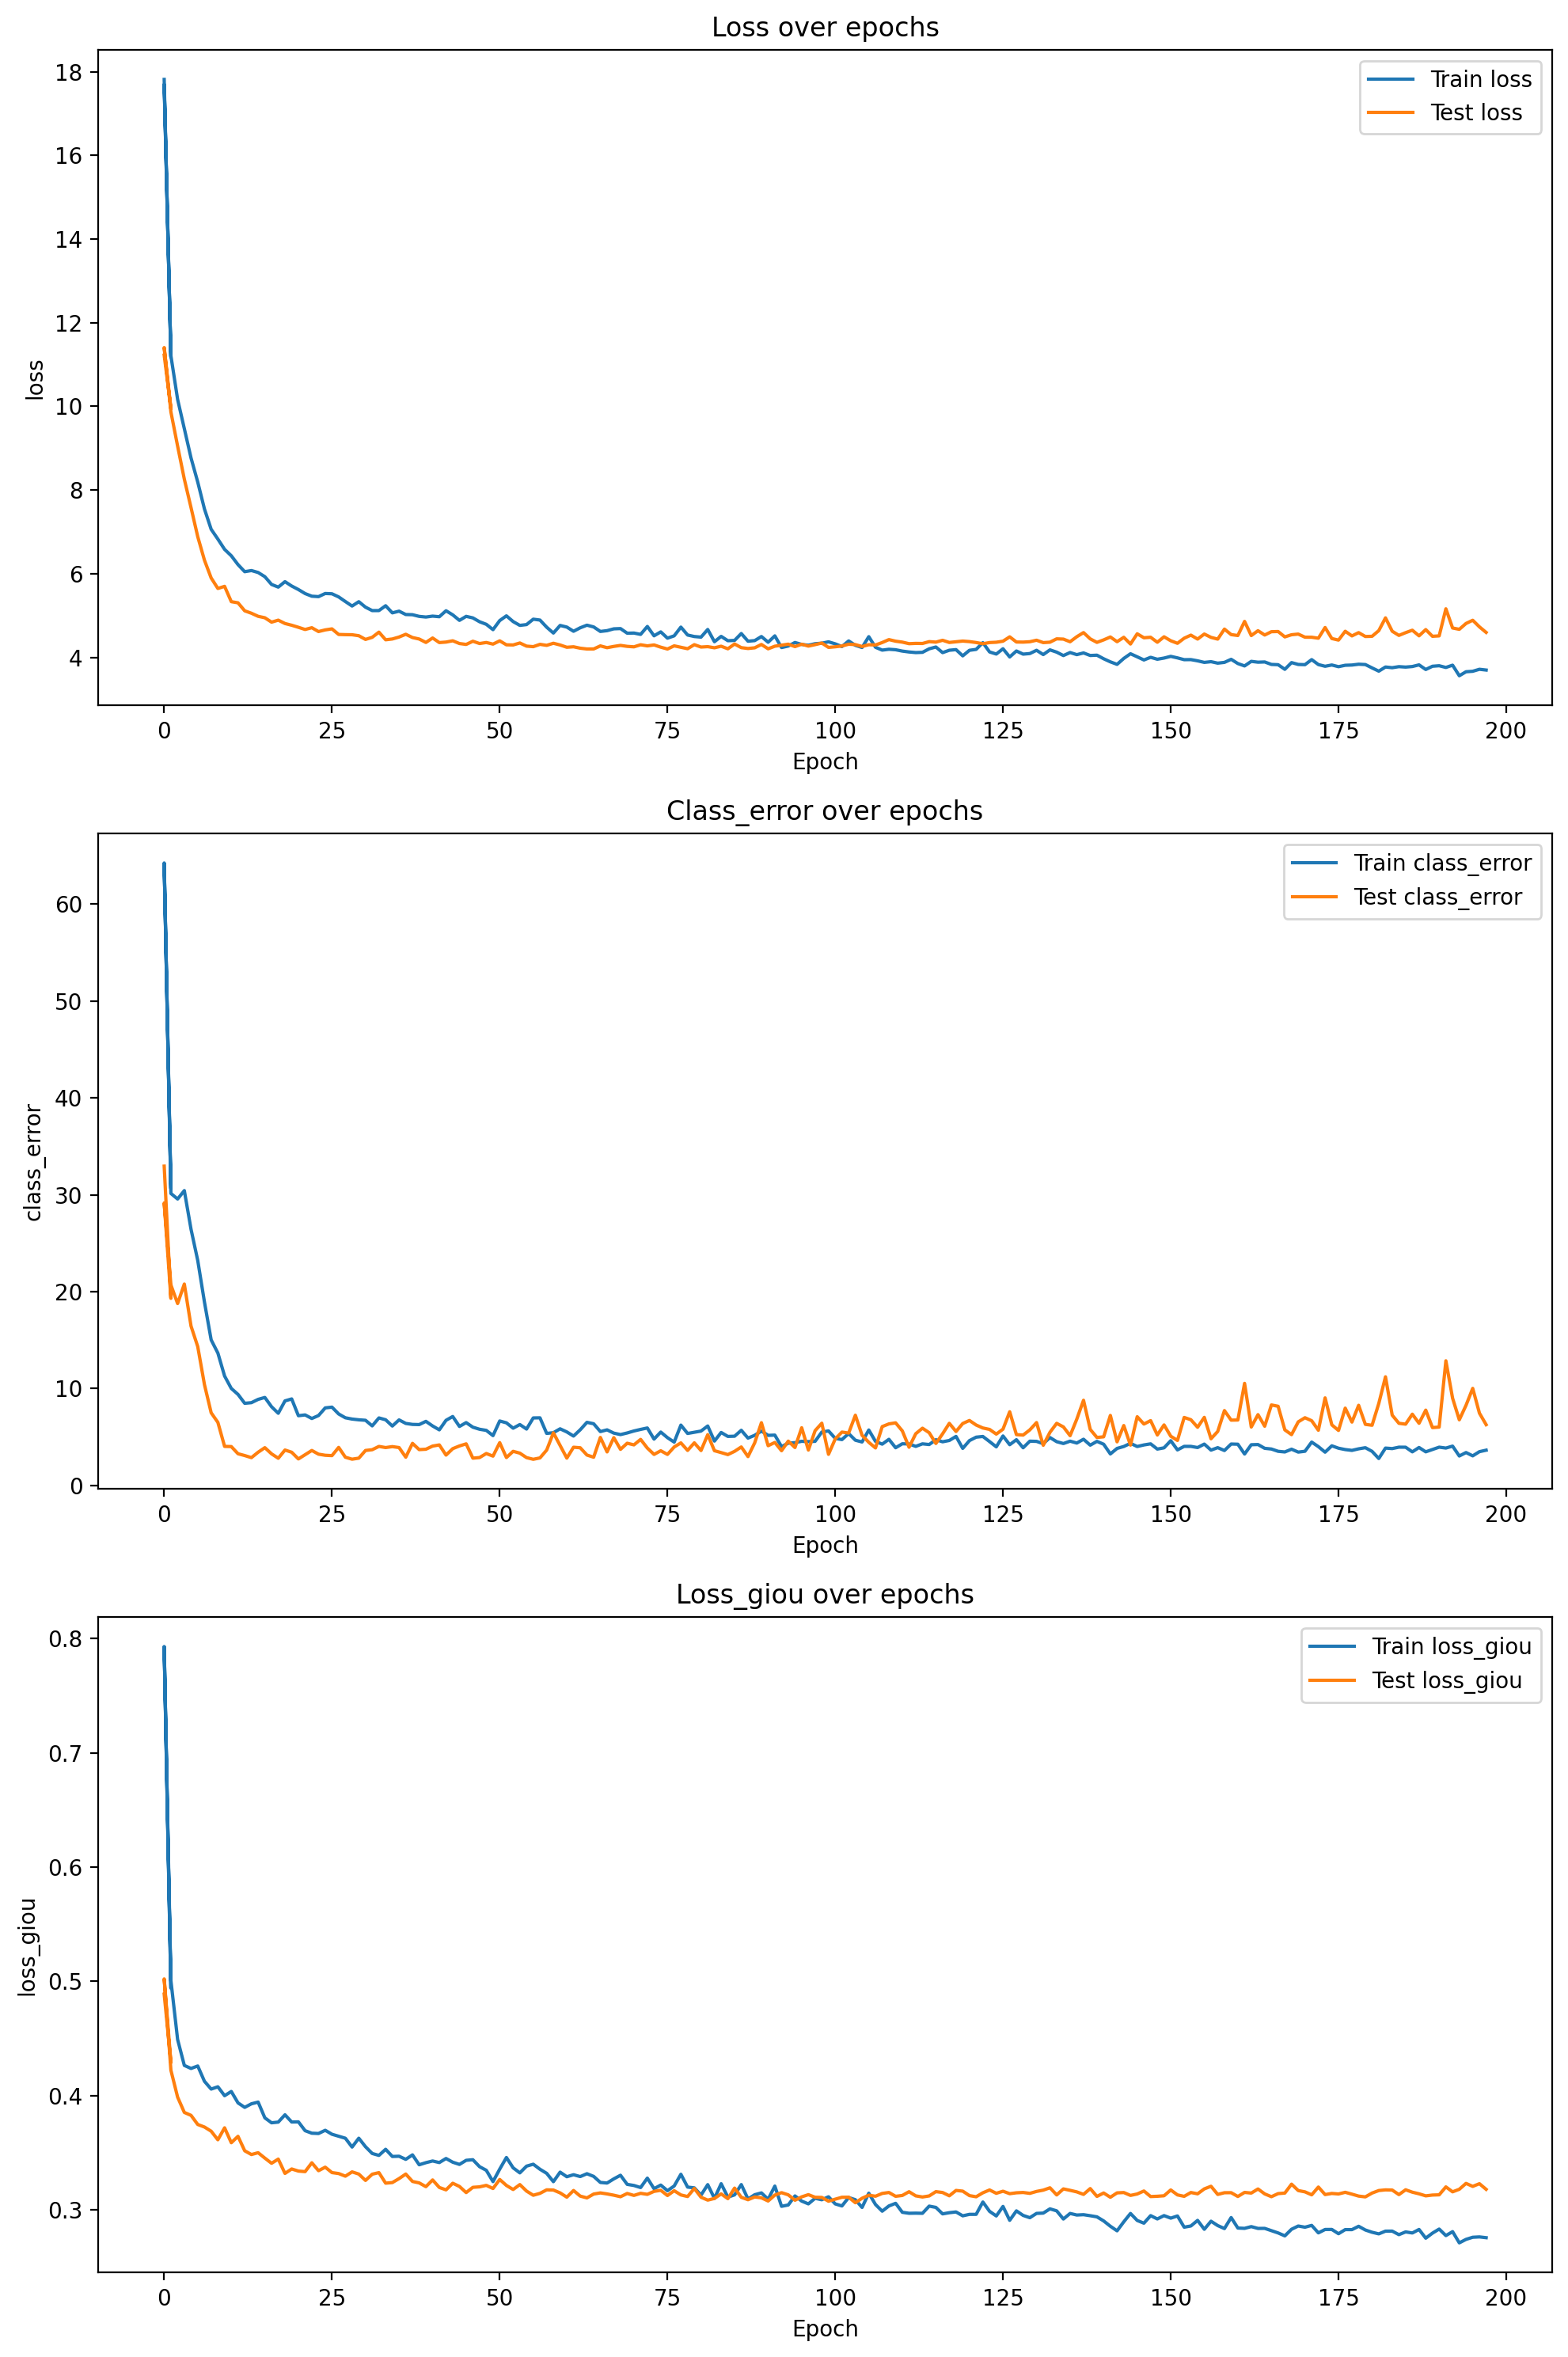

In [28]:
import ast
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Read the logs from logs.txt
logs = []
with open('./outputs/log.txt', 'r') as file:
    for line in file:
        # Safely evaluate each line as a dictionary and append it to the logs list
        logs.append(ast.literal_eval(line.strip()))

# Define the plot_metrics function as provided previously
def plot_metrics(data, metrics):
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)
    
    # Plot setup
    fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 5 * len(metrics)))
    if len(metrics) == 1:
        axs = [axs]  # Ensure axs is iterable for a single metric case
    
    for i, metric in enumerate(metrics):
        # Plot training metric
        axs[i].plot(df['epoch'], df[f'train_{metric}'], label=f'Train {metric}')
        # Plot testing metric if available
        if f'test_{metric}' in df.columns:
            axs[i].plot(df['epoch'], df[f'test_{metric}'], label=f'Test {metric}')
        
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric)
        axs[i].legend()
        axs[i].set_title(f'{metric.capitalize()} over epochs')
    
    plt.tight_layout()
    plt.savefig('./training_plot.png')
    plt.show()

# Step 2: Visualize the logs
metrics = ['loss', 'class_error', 'loss_giou']  # Specify the metrics you want to plot
plot_metrics(logs, metrics)


In [10]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

import argparse

In [11]:
import torch
from pathlib import Path

# Assuming the necessary imports from your model's code are available
from models import build_model  # Adjust the import path as needed

def load_model_for_inference(checkpoint_path, **model_kwargs):
    """
    Load a model for inference from a checkpoint file.

    Parameters:
    - checkpoint_path (str): Path to the model checkpoint (.pth) file.
    - device (str): Device to use for inference ('cuda' or 'cpu').
    - model_kwargs (dict): Additional keyword arguments for model initialization.

    Returns:
    - model: The loaded model ready for inference.
    """
    # device = torch.device(device)
    
    # Adjust the following model_args according to your model's requirements
    model_args = argparse.Namespace(**model_kwargs)
    
    model, _, _ = build_model(model_args)  # Assuming the function returns model, criterion, postprocessors
    model.to(device)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'], strict=False)
    model.eval()  # Set the model to inference mode
    
    return model

# Example usage in a notebook cell:
checkpoint_path = "./outputs/checkpoint0199.pth"
device = 'cuda'  # or 'cpu'
num_classes = 4

# Example model_kwargs, replace with actual ones needed for your model
model_kwargs = {
    'lr': 1e-4,
    'lr_backbone': 1e-5,
    'batch_size': 2,
    'weight_decay': 1e-4,
    'epochs': 300,
    'lr_drop': 200,
    'clip_max_norm': 0.1,
    'num_classes': num_classes,
    'frozen_weights': None,
    'backbone': 'resnet50',
    'dilation': False,
    'position_embedding': 'sine',
    'enc_layers': 6,
    'dec_layers': 6,
    'dim_feedforward': 2048,
    'hidden_dim': 256,
    'dropout': 0.1,
    'nheads': 8,
    'num_queries': 100,
    'pre_norm': False,
    'masks': False,
    'aux_loss': True,  # Note: Changed from 'no_aux_loss' for clarity in dict form
    'set_cost_class': 1,
    'set_cost_bbox': 5,
    'set_cost_giou': 2,
    'mask_loss_coef': 1,
    'dice_loss_coef': 1,
    'bbox_loss_coef': 5,
    'giou_loss_coef': 2,
    'eos_coef': 0.1,
    'dataset_file': 'coco',
    'coco_path': '',  # Specify your path if needed
    'coco_panoptic_path': '',  # Specify your path if needed
    'remove_difficult': False,
    'device': device,
    'seed': 42,
    'start_epoch': 0,
    'eval': False,
    'num_workers': 2,
    'world_size': 1,
    'dist_url': 'env://'
}

detr = load_model_for_inference(checkpoint_path, **model_kwargs)
print("Model loaded and ready for inference.")
# Now you can use the model for inference, e.g., model(input_tensor)


Building a DETR model with 4 classes


C:\ProgramData\anaconda3\envs\detr_training\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\detr_training\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded and ready for inference.


In [12]:
# COCO classes
CLASSES = [
    'cells', 'Platelets', 'RBC', 'WBC'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [13]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    scale_tensor = torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)  # Move to the same device
    b = b * scale_tensor
    return b


In [17]:
# Update the detect function to pass the device to rescale_bboxes
def detect(im, model, transform):
    img = transform(im).unsqueeze(0)

    device = next(model.parameters()).device
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)  # Pass the device here
    return probas[keep], bboxes_scaled


In [18]:
url = './datasets/COCO_dataset/archive/valid/BloodImage_00026_jpg.rf.7937b64ebbc36c4e543219b113a85501.jpg'
im = Image.open(url)

scores, boxes = detect(im, detr, transform)

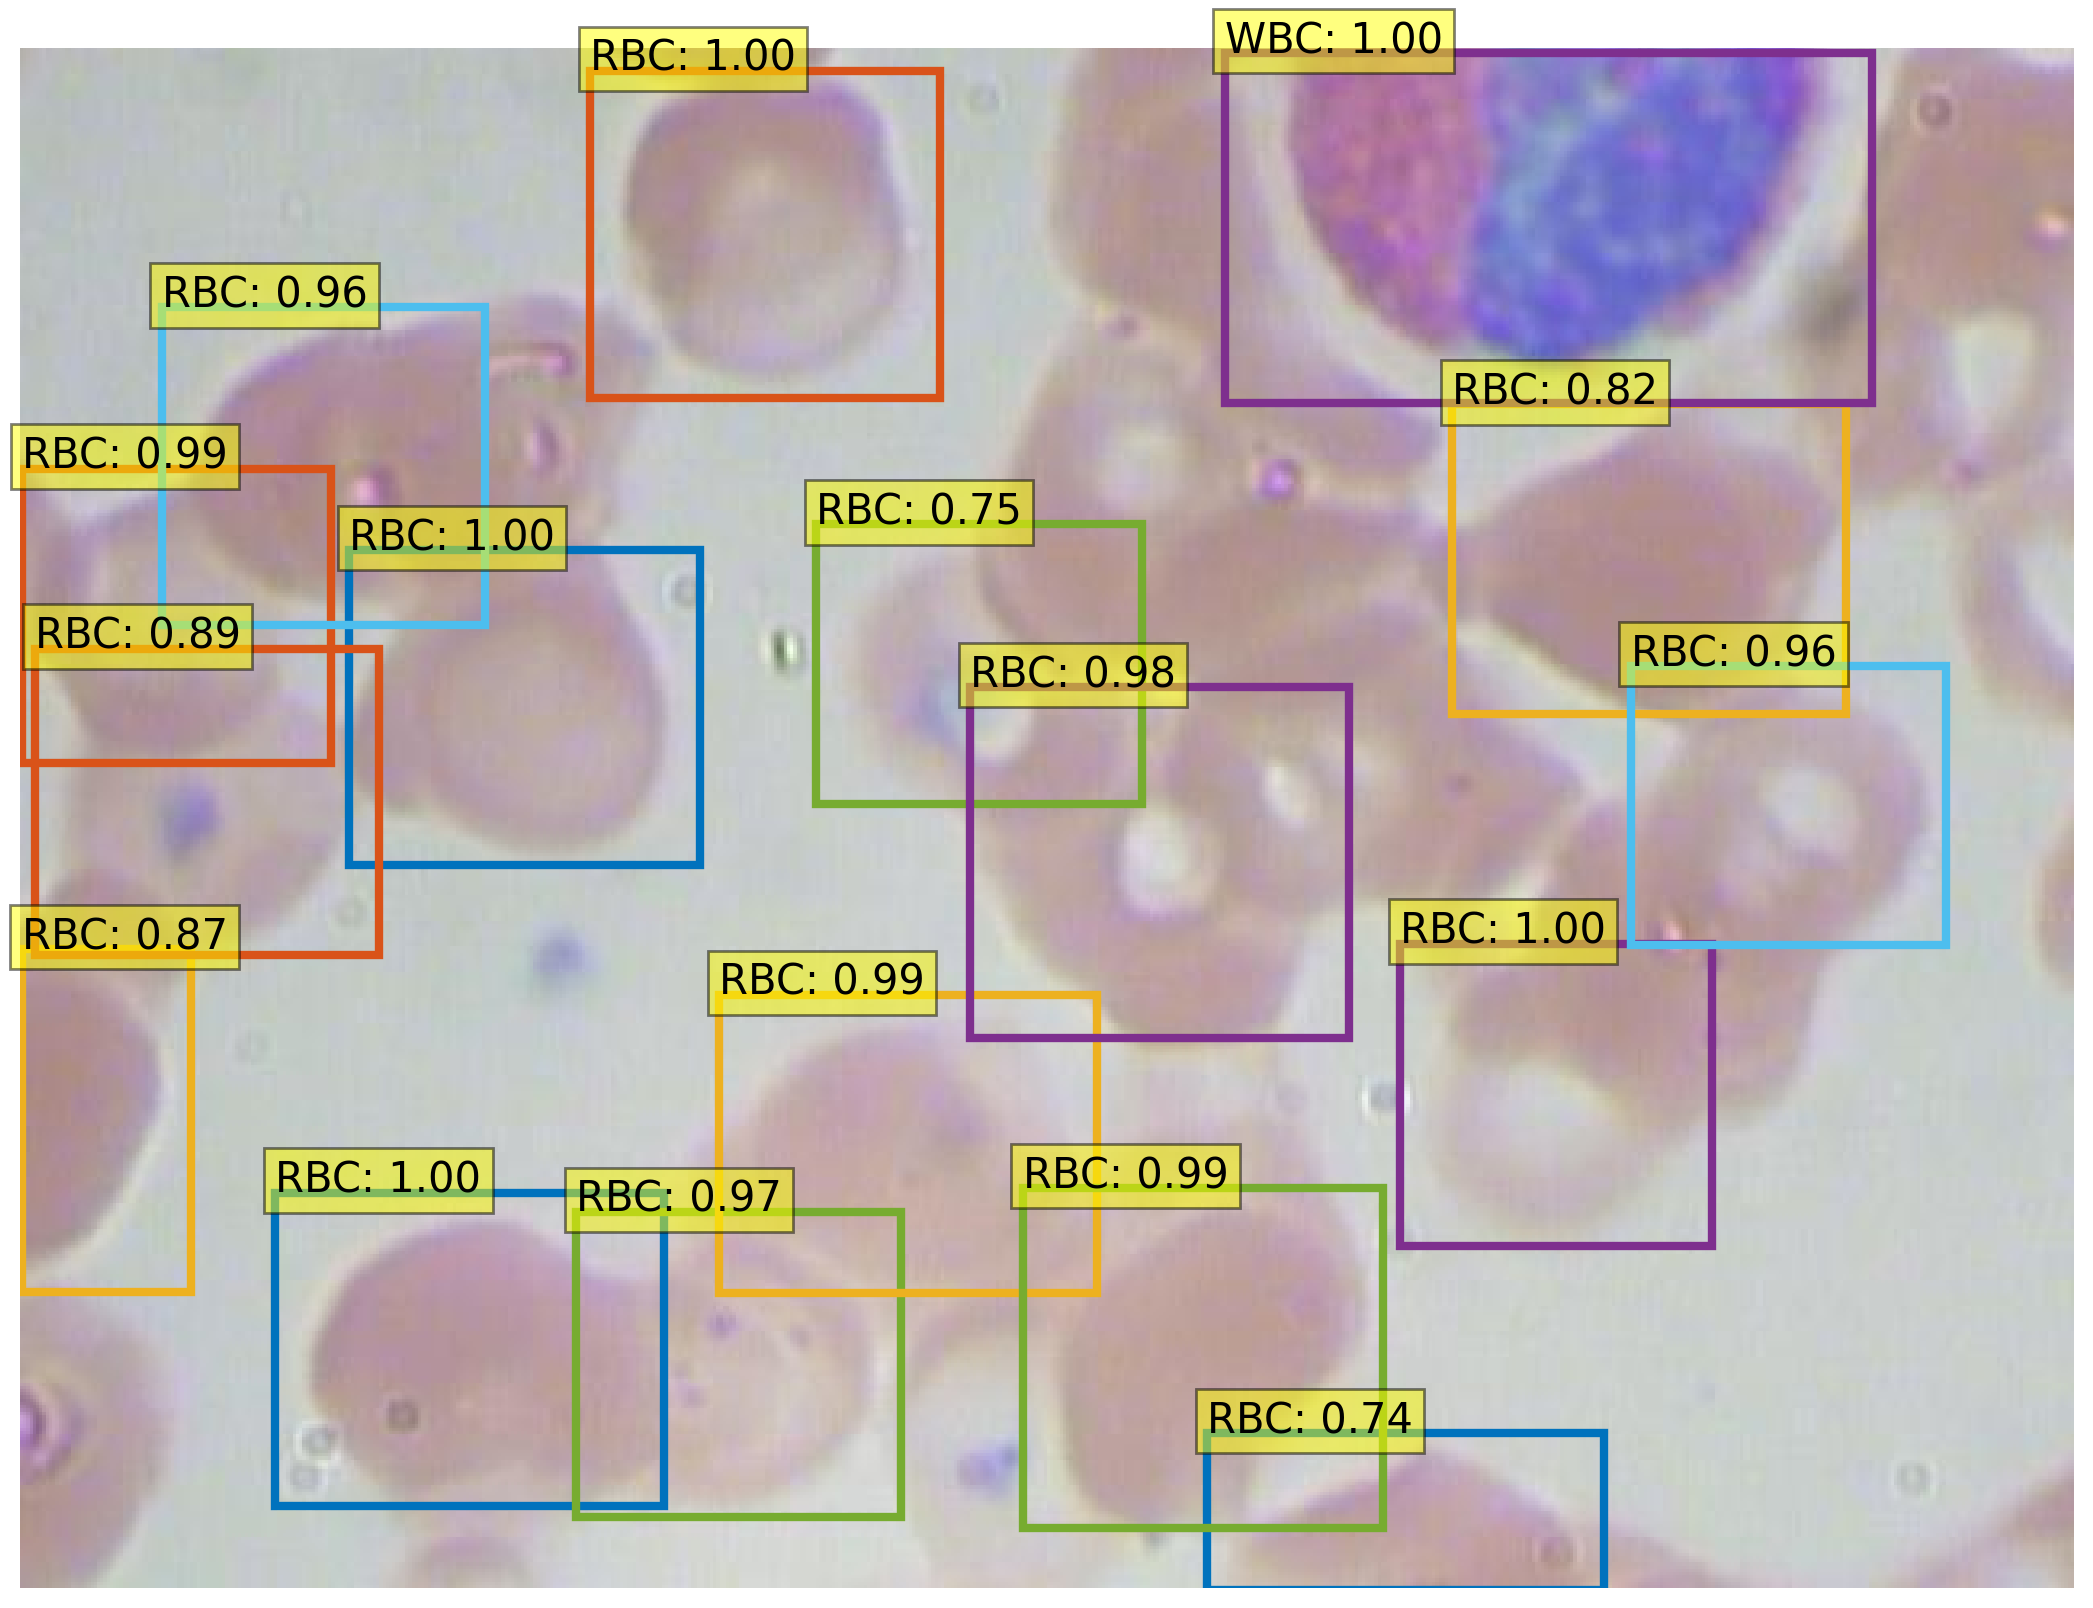

In [29]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.savefig('./cell_output.png')
    plt.show()

plot_results(im, scores, boxes)